In [1]:
import numpy as np
import pandas as pd
import os
import random
from pathlib import Path as pt
import torch
import torchaudio
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchaudio import transforms
from torchvision.transforms import v2
# from Moduls.MosreDataset import MosreDataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.nn.parallel import DataParallel
from collections import Counter

DIVICE = torch.device("cuda")

MAIN = pt(os.getcwd())
DATASET_PATCH = MAIN / 'morse_dataset'
AUDIO_FILES = DATASET_PATCH / 'morse_dataset'

# Поятоянные значения выявленные в процессе анализа
MORSEALP = "АБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯ 1234567890#"
MAX_TIME = 48
SAMPLE_RATE = 8000
N_MELS = 128
N_FFT = 400
HOP_LENGTH = 180
TOP_DB = 80
FREQ_MASK = 15
TIME_MASK = 20

# Гиперпараметы обучения
SEED = 42
BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 0.002 #2e-4
WEIGHT_DECAY = 0.00001
# int_to_alph = dict(enumerate(MORSEALP))
# alph_to_int = {char:enum for enum, char in int_to_alph.items()}

#===== Import data =====
train_data = pd.read_csv(pt.joinpath(DATASET_PATCH,'train.csv'))
test_data = pd.read_csv(pt.joinpath(DATASET_PATCH,'test.csv'))
sample_data = pd.read_csv(pt.joinpath(DATASET_PATCH,'sample_submission.csv'))

all_chars = Counter("".join(train_data['message']))
BLANK_CHAR = "_"
vocab_list = sorted(all_chars.keys()) + [BLANK_CHAR]
num_classes = len(vocab_list)
char_to_int = {char: i for i, char in enumerate(vocab_list)}
int_to_char = {i: char for i, char in enumerate(vocab_list)}
BLANK_IDX = char_to_int[BLANK_CHAR]

class MosreDataset(Dataset):
    """
    Класс для обработки 
    """
    def __init__(self, df, data_patch,char_to_int, train=True, transforms=None, prev_chars = 1):
        self.df = df
        self.is_train = train

        self.data_path = data_patch
        self.audio_paths = self.data_path / 'morse_dataset'

        self.transforms = transforms

        self.char_to_int = char_to_int
        self.prev_chars = prev_chars

        if self.is_train:
            self.messeges = self.df.message.values

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        #Получение аугментрованых спектрограмм
        try:
            audio_file = self.audio_paths / self.df.id.values[index]
            waveform, sample_rate = torchaudio.load(audio_file)
            augmented_spectrogram = self.transforms(waveform)

            if self.is_train:
                message = self.messeges[index]
                #Получение списка индексов секта - как требует CTC los
                '''
                При обработке dataloader labels будут выравниваться по макс длине для выравнивания батча
                Т.е. будет padding 0. что в будующем будет пустым значением для ctc loss
                '''
                target = torch.tensor([self.char_to_int[char] for char in message], dtype=torch.long); 
                target_len = torch.tensor(len(target), dtype=torch.long)
                return augmented_spectrogram, target, target_len, message
            else:
                return augmented_spectrogram, None, None, None
        except Exception as ex:
            print(str(ex))
        
    def change_time(self, audio_file, max_len = 384000):
        waveform, sample_rate = torchaudio.load(audio_file)
        cahanal, sig_len = waveform.shape

        if sig_len < max_len:
            pad_len = torch.zeros(max_len - sig_len).unsqueeze(0)
            waveform = torch.cat([waveform, pad_len], dim=1)

        return waveform
    
FIRST_FE_COUNT = 16
SECOND_FE_COUNT = 32
THIRD_FE_COUNT = 32
QAD_FE_COUNT = 32
PADDING = 'same'
MAXPOOL_KERNEL = 2
KERTNEL_SIZE = 3
NERON_COUNT = 128
GRU_HIDEN = 256
# Start with 4 transforms
class MorseNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.net_conv = nn.Sequential(
            nn.Conv2d(in_channels=1, 
                      out_channels=FIRST_FE_COUNT, 
                      kernel_size=KERTNEL_SIZE , stride=1, padding=PADDING),
            nn.BatchNorm2d(FIRST_FE_COUNT),
            nn.GELU(),
            nn.MaxPool2d((1, 2), (1, 2)), # [batch, FIRST_FE_COUNT = 16, 64, 960]

            nn.Conv2d(in_channels=FIRST_FE_COUNT, 
                      out_channels=SECOND_FE_COUNT, 
                      kernel_size=KERTNEL_SIZE , stride=1, padding=PADDING),
            nn.BatchNorm2d(SECOND_FE_COUNT),
            nn.GELU(),
            nn.MaxPool2d((2, 1), (2, 1)), # [batch, SECOND_FE_COUNT = 32, 32, 480]

            nn.Conv2d(in_channels=SECOND_FE_COUNT, 
                      out_channels=THIRD_FE_COUNT, 
                      kernel_size=KERTNEL_SIZE , stride=1, padding=PADDING),
            nn.BatchNorm2d(THIRD_FE_COUNT),
            nn.GELU(),
            nn.MaxPool2d((2, 2), (2, 2)), # [batch, THIRD_FE_COUNT = 32, 16, 240]

            nn.Conv2d(in_channels=THIRD_FE_COUNT, 
                      out_channels=QAD_FE_COUNT, 
                      kernel_size=KERTNEL_SIZE , stride=1, padding=PADDING),
            nn.BatchNorm2d(QAD_FE_COUNT),
            nn.GELU(),
            nn.MaxPool2d((2, 1), (2, 1)) # [batch=32, QAD_FE_COUNT = 32, 8, 80](что юы сохраниить большще признаков по горизонтали)
        )
        with torch.no_grad(): 
            dummy_input = torch.randn(1, 1, N_MELS, 356); 
            cnn_out = self.net_conv(dummy_input); 
            self.cnn_output_features = cnn_out.shape[1] * cnn_out.shape[2]

        print(f"CNN размерность выхода: {cnn_out.shape}"); 
        print(f"CNN число фичей: {self.cnn_output_features}")

        # Добавлен лоейный слой и функция активации. Для чего? расписать потом 
        self.layer1 = nn.Linear(self.cnn_output_features, N_MELS*2); 
        self.gelu = nn.GELU()
        print(f"Проекция из {self.cnn_output_features} в {GRU_HIDEN*2}")
        self.rnn = nn.LSTM(
                input_size=N_MELS*2,
                hidden_size=GRU_HIDEN,
                num_layers=2,
                bidirectional=True,
                dropout=0.3,
                batch_first=True 
            )

        
        self.embed_dim = GRU_HIDEN * 2
        self.layer_norm = nn.LayerNorm(self.embed_dim)      
        self.dropout = nn.Dropout(0.3)   
        self.layer2 = nn.Linear(self.embed_dim, num_classes)       
        # self.layer3 = nn.Linear(GRU_HIDEN, GRU_HIDEN // 2)       
        # self.layer4 = nn.Linear(GRU_HIDEN // 2, 45)             

    def name(self):
        return 'MorseNet1'

    def forward(self, x):
        x = self.net_conv(x)

        batch, channels, reduced_mels, reduced_time = x.shape
        x = x.permute(0, 3, 1, 2)  # [batch, time, channels, mels]

        # В частности, каждый вектор признаков в последовательности признаков генерируется 
        # слева направо на картах признаков. Это означает, что i-й вектор признаков представляет 
        # собой объединение столбцов всех карт. 
        # Таким образом, форма тензора может быть изменена, например, на (размер_пакета, 80, 256)
        
        x = x.reshape(batch, reduced_time, -1)  # to GRU [batch=32, seq_len=89, features/hiden_dim=512]
        x = self.layer1(x)
        x = self.gelu(x)

        self.rnn.flatten_parameters()

        x = self.rnn(x) # [batch=32, seq_len=89, features/hiden_dim=256 * 2]
        x, _ = x # берем информацию со всез состояний
        x = self.layer_norm(x)
        x = self.dropout(x)
        x = self.layer2(x) # logits - [batch, sequence, num_classes] 
        x = nn.functional.log_softmax(x.permute(1,0,2), dim=2) # pertime так как CTC loss требует на взод (sequence/T,batch/N,num_classes/C)
        '''
        по одному прогнозу для каждого из признаков в последовательности, 
        в итоге получается 89 прогнозов символов для каждой секунды звука.
        '''
        return x
    
    
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.squeeze = nn.AdaptiveAvgPool2d(1)  # [B, C, 1, 1]
        self.excitation = nn.Sequential(
            nn.Linear(channels, channels // reduction),  # [B, C/reduction]
            nn.GELU(),
            nn.Linear(channels // reduction, channels),  # [B, C]
            nn.Sigmoid()
        )
    
    def forward(self, x):
        B, C, _, _ = x.shape
        squeezed = self.squeeze(x).view(B, C)  # [B, C]
        weights = self.excitation(squeezed).view(B, C, 1, 1)  # [B, C, 1, 1]
        return x * weights  # Масштабируем каналы
    

class MorseNet2(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        # start - [1, 128, 356]
        self.net_conv = nn.Sequential(
            nn.Conv2d(in_channels=1, 
                      out_channels=FIRST_FE_COUNT, 
                      kernel_size=KERTNEL_SIZE , stride=1, padding=PADDING),
            nn.BatchNorm2d(FIRST_FE_COUNT),
            nn.GELU(),
            SEBlock(FIRST_FE_COUNT),
            nn.MaxPool2d(kernel_size=2, stride=2), # [batch, FIRST_FE_COUNT = 16, 64, 178]

            nn.Conv2d(in_channels=FIRST_FE_COUNT, 
                      out_channels=SECOND_FE_COUNT, 
                      kernel_size=KERTNEL_SIZE , stride=1, padding=PADDING),
            nn.BatchNorm2d(SECOND_FE_COUNT),
            nn.GELU(),
            SEBlock(SECOND_FE_COUNT),
            # nn.MaxPool2d(2, 2), #

            nn.Conv2d(in_channels=SECOND_FE_COUNT, 
                      out_channels=THIRD_FE_COUNT, 
                      kernel_size=KERTNEL_SIZE , stride=1, padding=PADDING),
            nn.BatchNorm2d(THIRD_FE_COUNT),
            nn.GELU(),
            SEBlock(THIRD_FE_COUNT),
            # nn.MaxPool2d((2, 2), (2, 2)), 

            nn.Conv2d(in_channels=THIRD_FE_COUNT, 
                      out_channels=QAD_FE_COUNT, 
                      kernel_size=KERTNEL_SIZE , stride=1, padding=PADDING),
            nn.BatchNorm2d(QAD_FE_COUNT),
            # SEBlock(QAD_FE_COUNT),
            nn.GELU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # [batch=32, QAD_FE_COUNT = 32, 32, 89]
        )
        with torch.no_grad(): 
            dummy_input = torch.randn(1, 1, N_MELS, 356); 
            cnn_out = self.net_conv(dummy_input); 
            self.cnn_output_features = cnn_out.shape[1] * cnn_out.shape[2]

        print(f"CNN размерность выхода: {cnn_out.shape}"); 
        print(f"CNN число фичей: {self.cnn_output_features}")

        # Добавлен лоейный слой и функция активации. Для чего? расписать потом 
        self.layer1 = nn.Linear(self.cnn_output_features, N_MELS*2, bias=False); 
        self.gelu = nn.GELU()
        self.rnn = nn.LSTM(
                input_size=N_MELS*2,
                hidden_size=GRU_HIDEN,
                num_layers=2,
                bidirectional=True,
                dropout=0.3,
                batch_first=True 
            )

        
        self.embed_dim = GRU_HIDEN * 2
        self.layer_norm = nn.LayerNorm(self.embed_dim)      
        self.dropout = nn.Dropout(0.5)   
        self.layer2 = nn.Linear(self.embed_dim, num_classes)      

    def name(self):
        return 'MorseNet2'

    def forward(self, x):
        x = self.net_conv(x)

        batch, channels, reduced_mels, reduced_time = x.shape
        x = x.permute(0, 3, 1, 2)  # [batch, time, channels, mels]

        # В частности, каждый вектор признаков в последовательности признаков генерируется 
        # слева направо на картах признаков. Это означает, что i-й вектор признаков представляет 
        # собой объединение столбцов всех карт. 
        # Таким образом, форма тензора может быть изменена, например, на (размер_пакета, 80, 256)
        
        x = x.reshape(batch, reduced_time, -1)  # to GRU [batch=32, seq_len=89, features/hiden_dim=512]
        x = self.layer1(x)
        x = self.gelu(x)

        self.rnn.flatten_parameters()

        x = self.rnn(x) # [batch=32, seq_len=89, features/hiden_dim=256 * 2]
        x, _ = x # берем информацию со всез состояний
        x = self.layer_norm(x)
        x = self.dropout(x)
        x = self.layer2(x) # logits - [batch, sequence, num_classes] 
        x = nn.functional.log_softmax(x.permute(1,0,2), dim=2) # pertime так как CTC loss требует на взод (sequence/T,batch/N,num_classes/C)
        '''
        по одному прогнозу для каждого из признаков в последовательности, 
        в итоге получается 89 прогнозов символов для каждой секунды звука.
        # '''
        return x

class MorseNet3(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.net_conv = nn.Sequential(
            nn.Conv2d(in_channels=1, 
                      out_channels=FIRST_FE_COUNT, 
                      kernel_size=KERTNEL_SIZE , stride=1, padding=PADDING),
            nn.BatchNorm2d(FIRST_FE_COUNT),
            nn.GELU(),
            nn.MaxPool2d((1,2)), # [batch, FIRST_FE_COUNT = 16, 64, 960]

            nn.Conv2d(in_channels=FIRST_FE_COUNT, 
                      out_channels=SECOND_FE_COUNT, 
                      kernel_size=KERTNEL_SIZE , stride=1, padding=PADDING),
            nn.BatchNorm2d(SECOND_FE_COUNT),
            nn.GELU(),
            nn.MaxPool2d((2,1)), # [batch, SECOND_FE_COUNT = 32, 32, 480]

            nn.Conv2d(in_channels=SECOND_FE_COUNT, 
                      out_channels=THIRD_FE_COUNT, 
                      kernel_size=KERTNEL_SIZE , stride=1, padding=PADDING),
            nn.BatchNorm2d(THIRD_FE_COUNT),
            nn.GELU(),
            nn.MaxPool2d((2,2)), # [batch, THIRD_FE_COUNT = 32, 16, 240]

            nn.Conv2d(in_channels=THIRD_FE_COUNT, 
                      out_channels=QAD_FE_COUNT, 
                      kernel_size=KERTNEL_SIZE , stride=1, padding=PADDING),
            nn.BatchNorm2d(QAD_FE_COUNT),
            nn.GELU(),
            nn.MaxPool2d((1,2)) # [batch=32, QAD_FE_COUNT = 32, 8, 80](что юы сохраниить большще признаков по горизонтали)
        )

        with torch.no_grad(): 
            dummy_input = torch.randn(1, 1, N_MELS, 356)
            cnn_out = self.net_conv(dummy_input)
            self.cnn_output_features = cnn_out.shape[1] * cnn_out.shape[2]
        
        self.cnn_ln = nn.LayerNorm(self.cnn_output_features)  # NEW
        
        self.layer1 = nn.Linear(self.cnn_output_features, N_MELS*2)
        self.gelu = nn.GELU()
        self.ln1 = nn.LayerNorm(N_MELS*2)
        
        self.rnn = nn.LSTM(
            input_size=N_MELS*2,
            hidden_size=GRU_HIDEN,
            num_layers=2,
            bidirectional=True,
            dropout=0.3,
            batch_first=True
        )
        
        self.rnn_ln = nn.LayerNorm(GRU_HIDEN*2)
        self.dropout = nn.Dropout(0.3)
        self.layer2 = nn.Linear(GRU_HIDEN*2, num_classes)

    def name(self):
        return 'MorseNet3'
    
    def forward(self, x):
        x = self.net_conv(x)
        batch, channels, reduced_mels, reduced_time = x.shape
        x = x.permute(0, 3, 1, 2)
        x = x.reshape(batch, reduced_time, -1)
        
        x = self.cnn_ln(x)
        
        x = self.layer1(x)
        x = self.gelu(x)
        x = self.ln1(x)
        
        self.rnn.flatten_parameters()
        x, _ = self.rnn(x)
        x = self.rnn_ln(x)
        
        x = self.dropout(x)
        x = self.layer2(x)
        x = nn.functional.log_softmax(x.permute(1,0,2), dim=2)
        return x
    
  
train_audio_transforms = nn.Sequential(
    transforms.MelSpectrogram(sample_rate=SAMPLE_RATE, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS),
    transforms.AmplitudeToDB(top_db=TOP_DB),
    transforms.FrequencyMasking(freq_mask_param=FREQ_MASK),
    transforms.TimeMasking(time_mask_param=TIME_MASK),
    # v2.RandomCrop((N_MELS, 1920)) # Обрезает последний кадр спектрограммы, в идеале надобы считать а не прописывать число
    ) # заметка - Данные трансформации не создают довых обучаемых параметров. Но есть и те что создают. В будущем это стоит учитывать

valid_audio_transforms = nn.Sequential(
    transforms.MelSpectrogram(sample_rate=SAMPLE_RATE, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS),
    transforms.AmplitudeToDB(top_db=TOP_DB),
    # v2.CenterCrop((N_MELS, 1920)) 
    )

train_dataframe, val_dataframe = train_test_split(train_data, test_size=0.15, random_state=SEED)

train_ds = MosreDataset(df=train_dataframe,
                        data_patch=DATASET_PATCH,
                        char_to_int=char_to_int,
                        train=True,
                        transforms=train_audio_transforms)

val_ds = MosreDataset(df=val_dataframe,
                        data_patch=DATASET_PATCH,
                        char_to_int=char_to_int,
                        train=True,
                        transforms=valid_audio_transforms)


def my_collate(batch):
    spectrograms = [item[0].squeeze(0) for item in batch]
    # Падинг спектрограмм по максимальной длине
    spectrograms_permuted = [s.permute(1, 0) for s in spectrograms]
    spectrograms_padded = nn.utils.rnn.pad_sequence(spectrograms_permuted, batch_first=True, padding_value=0.0)
    spectrograms_padded = spectrograms_padded.permute(0, 2, 1).unsqueeze(1)

    if batch[0][3] is not None:
        target = torch.nn.utils.rnn.pad_sequence(
                                                [item[1] for item in batch], 
                                                batch_first=True, 
                                                padding_value=BLANK_IDX)# выравнивает последовательность до макс 
                                                                        # длины в батче заполняя пропуски нулем
        label_len = torch.stack([item[2] for item in batch])
        msg = [item[3] for item in batch]
        
        return [spectrograms_padded, target, label_len, msg]
    else: 
        return spectrograms_padded

train_dl = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=my_collate, drop_last=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=my_collate, drop_last=True)

test, test_target, _, mess = next(iter(train_dl))
test, test_target= test.to(DIVICE), test_target.to(DIVICE)

test_val, val_target, __, val_mess = next(iter(val_dl))
test_val, val_target = test_val.to(DIVICE), val_target.to(DIVICE)
# test.shape 

#===== начало обучения =====
models = [
    MorseNet(num_classes=num_classes).to(DIVICE),
    MorseNet2(num_classes=num_classes).to(DIVICE),
    MorseNet3(num_classes=num_classes).to(DIVICE)
]

optimizers = [
    optim.Adam(params=models[0].parameters(), lr=0.0002, weight_decay=WEIGHT_DECAY),
    optim.Adam(params=models[1].parameters(), lr=0.0002, weight_decay=WEIGHT_DECAY),
    optim.AdamW(params=models[2].parameters(), lr=0.0002, weight_decay=WEIGHT_DECAY),
]

schedulers = [
    optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
    for optimizer in optimizers
]

# model = MorseNet(num_classes=num_classes).to(DIVICE)
# # model = DataParallel(model)
# optimizer = optim.Adam(params=model.parameters(), lr=0.002)  # Было 0.002
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
loss_func = nn.CTCLoss(blank=BLANK_IDX, reduction='mean', zero_infinity=True).to(DIVICE)

total_params = sum(p.numel() for m in models for p in m.parameters() if p.requires_grad)
print(f"\nMorseNet - инициалицация модели. Число обучаемых параметров: {total_params:,}")

CNN размерность выхода: torch.Size([1, 32, 16, 89])
CNN число фичей: 512
Проекция из 512 в 512
CNN размерность выхода: torch.Size([1, 32, 32, 89])
CNN число фичей: 1024

MorseNet - инициалицация модели. Число обучаемых параметров: 8,690,588


In [7]:
for model, optimizer, scheduler in zip(model, optimizers, schedulers):
    print(model.name())

MorseNet1
MorseNet2
MorseNet3


In [26]:
# BLANK_CHAR = "_"
# vocab_list = sorted(all_chars.keys()) + [BLANK_CHAR]
# num_classes = len(vocab_list)
# char_to_int = {char: i for i, char in enumerate(vocab_list)}
# int_to_char = {i: char for i, char in enumerate(vocab_list)}
# BLANK_IDX = char_to_int[BLANK_CHAR]
# vocab_list

In [3]:
# a= model(test)
# a.shape, a

In [54]:
_.reshape(BATCH_SIZE)

tensor([ 8, 12,  7, 11,  9, 10,  8, 11,  8,  9,  8,  8, 11, 10,  9, 11, 11,  9,
         7,  8,  8,  9, 11,  8,  9,  9,  9,  8, 10,  8,  6, 11])

Подсказка по ctc loss

In [5]:
# Target are to be un-padded
T = 50      # Input sequence length
C = 20      # Number of classes (including blank)
N = 16      # Batch size
# Initialize random batch of input vectors, for *size = (T,N,C)
input = torch.randn(T, N, C).log_softmax(2).detach().requires_grad_()
input_lengths = torch.full(size=(N,), fill_value=T, dtype=torch.long)
# Initialize random batch of targets (0 = blank, 1:C = classes)
target_lengths = torch.randint(low=1, high=T, size=(N,), dtype=torch.long)
target = torch.randint(low=1, high=C, size=(sum(target_lengths),), dtype=torch.long)
ctc_loss = nn.CTCLoss()
loss = ctc_loss(input, target, input_lengths, target_lengths)
loss.backward()
# input.detach().numpy().shape
loss.grad

C:\Users\homer\AppData\Local\Temp\ipykernel_20744\2733710114.py:15: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\build\aten\src\ATen/core/TensorBody.h:494.)
  loss.grad


In [9]:
input.shape, target.shape

(torch.Size([50, 16, 20]), torch.Size([334]))

# Обучение модели

In [2]:
dict_loss_train = {
    'MorseNet1': 0,
    'MorseNet2':0,
    'MorseNet3':0
}

dict_loss_val = {
    'MorseNet1': 0,
    'MorseNet2':0,
    'MorseNet3':0
}
for epoch in range(EPOCHS):

    for model, optimizer, scheduler in zip(models, optimizers, schedulers):
        model.train()
        model_name = model.name()
        epoch_train_loss = 0.0
        train_predicts = []

        train_tqdm = tqdm(train_dl, desc=f"{model_name}-Эпоха {epoch+1}/{EPOCHS} [Обучение]", leave=False)
        for batch_ind, batch in enumerate(train_tqdm):
            mel_spec, targets, targets_lens, _ = batch
            mel_spec, targets, targets_lens = mel_spec.to(DIVICE), targets.to(DIVICE), targets_lens.to(DIVICE)

            #===== считатем длинну mel_spec для передачи в CTC loss =====
            
            optimizer.zero_grad()
            predict = model(mel_spec) # (N=batch,T,C)
            N = predict.shape[1]
            T = predict.shape[0]
            predict_lengths = torch.full(size=(N,), fill_value=T, dtype=torch.long)

            try:
                loss = loss_func(predict, targets, predict_lengths, targets_lens.reshape(BATCH_SIZE))
            except RuntimeError:
                print(predict.shape, targets.shape, predict_lengths, targets_lens.reshape(BATCH_SIZE))
                continue
            # print(loss)
            if torch.isnan(loss) or torch.isinf(loss): 
                print(f"\nWarning: In batch-{batch_ind} loss train is NaN/Inf: {loss.item()}"); 
                optimizer.zero_grad(); 
                continue

            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            epoch_train_loss += loss.item()

        train_loss = epoch_train_loss / len(train_dl)

        # ======== Валидация ========
        model.eval()
        val_loss = 0.0
        total_val = 0
        val_predicts = []

        with torch.no_grad():
            for val_mel_spec, val_labels, val_label_lensin, _ in tqdm(
                                                            val_dl, 
                                                            desc=f"{model_name}-Эпоха {epoch+1}/{EPOCHS} [Валидация]", 
                                                            leave=False):
                val_mel_spec, val_labels, val_label_lensin = val_mel_spec.to(DIVICE), val_labels.to(DIVICE), val_label_lensin.to(DIVICE)
                val_predict = model(val_mel_spec)

                val_N = val_predict.shape[1]
                val_T = val_predict.shape[0]
                predict_val_lengths = torch.full(size=(val_N,), fill_value=val_T, dtype=torch.long)
                val_loss += loss_func(val_predict, val_labels, predict_val_lengths, val_label_lensin).item()

        total_val = val_loss / len(val_dl)

        dict_loss_train[model_name] = train_loss
        dict_loss_val[model_name] = total_val

        scheduler.step(total_val)
    

        print(f"\n===== {model_name}-Эпоха {epoch+1}/{EPOCHS}  =====")\
        #===== Инфо про градиенты=====
        grad_norms = [param.grad.norm().item() for param in model.parameters() if param.grad is not None]
        if grad_norms:
            print(f"{model_name}-Mean grad norm: {np.mean(grad_norms):.6f}")
            print(f"{model_name}-Max grad norm: {np.max(grad_norms):.6f}")
            print(f"{model_name}-Min grad norm: {np.min(grad_norms):.6f}")
        else:
            print("No gradients computed yet.")
        #===== Инфо про шаг обучения и данные по потерям =====
        current_lr = optimizer.param_groups[0]['lr']
        print(f"{model_name}-Current LR: {current_lr:.6f}")
        print(f"---- {model_name}-Train Loss: {train_loss:.4f}")
        print(f"---- {model_name}-Val Loss: {total_val:.4f}")
        if current_lr <= 1e-6:
            print(f"Learning rate достиг минимума 1e-6, остановка обучения {model_name}")
            break
        print("-" * 50)


===== MorseNet1-Эпоха 1/50  =====
MorseNet1-Mean grad norm: 0.079942
MorseNet1-Max grad norm: 0.634814
MorseNet1-Min grad norm: 0.000000
MorseNet1-Current LR: 0.000200
---- MorseNet1-Train Loss: 3.3026
---- MorseNet1-Val Loss: 0.9308
--------------------------------------------------



===== MorseNet2-Эпоха 1/50  =====
MorseNet2-Mean grad norm: 0.071480
MorseNet2-Max grad norm: 0.588758
MorseNet2-Min grad norm: 0.000000
MorseNet2-Current LR: 0.000200
---- MorseNet2-Train Loss: 3.5699
---- MorseNet2-Val Loss: 1.1367
--------------------------------------------------



===== MorseNet3-Эпоха 1/50  =====
MorseNet3-Mean grad norm: 0.078951
MorseNet3-Max grad norm: 0.535720
MorseNet3-Min grad norm: 0.000000
MorseNet3-Current LR: 0.000200
---- MorseNet3-Train Loss: 2.7226
---- MorseNet3-Val Loss: 0.8702
--------------------------------------------------



===== MorseNet1-Эпоха 2/50  =====
MorseNet1-Mean grad norm: 0.071358
MorseNet1-Max grad norm: 0.600421
MorseNet1-Min grad norm: 0.000000
MorseNet1-Current LR: 0.000200
---- MorseNet1-Train Loss: 0.8781
---- MorseNet1-Val Loss: 0.6600
--------------------------------------------------



===== MorseNet2-Эпоха 2/50  =====
MorseNet2-Mean grad norm: 0.060102
MorseNet2-Max grad norm: 0.653088
MorseNet2-Min grad norm: 0.000000
MorseNet2-Current LR: 0.000200
---- MorseNet2-Train Loss: 1.0002
---- MorseNet2-Val Loss: 0.5530
--------------------------------------------------



===== MorseNet3-Эпоха 2/50  =====
MorseNet3-Mean grad norm: 0.071266
MorseNet3-Max grad norm: 0.663711
MorseNet3-Min grad norm: 0.000000
MorseNet3-Current LR: 0.000200
---- MorseNet3-Train Loss: 0.9632
---- MorseNet3-Val Loss: 0.5846
--------------------------------------------------



===== MorseNet1-Эпоха 3/50  =====
MorseNet1-Mean grad norm: 0.076056
MorseNet1-Max grad norm: 0.581200
MorseNet1-Min grad norm: 0.000000
MorseNet1-Current LR: 0.000200
---- MorseNet1-Train Loss: 0.6158
---- MorseNet1-Val Loss: 0.3554
--------------------------------------------------



===== MorseNet2-Эпоха 3/50  =====
MorseNet2-Mean grad norm: 0.062949
MorseNet2-Max grad norm: 0.590566
MorseNet2-Min grad norm: 0.000000
MorseNet2-Current LR: 0.000200
---- MorseNet2-Train Loss: 0.6731
---- MorseNet2-Val Loss: 0.3663
--------------------------------------------------



===== MorseNet3-Эпоха 3/50  =====
MorseNet3-Mean grad norm: 0.071118
MorseNet3-Max grad norm: 0.660433
MorseNet3-Min grad norm: 0.000000
MorseNet3-Current LR: 0.000200
---- MorseNet3-Train Loss: 0.7228
---- MorseNet3-Val Loss: 0.4769
--------------------------------------------------



===== MorseNet1-Эпоха 4/50  =====
MorseNet1-Mean grad norm: 0.078827
MorseNet1-Max grad norm: 0.580675
MorseNet1-Min grad norm: 0.000000
MorseNet1-Current LR: 0.000200
---- MorseNet1-Train Loss: 0.5051
---- MorseNet1-Val Loss: 0.3105
--------------------------------------------------



===== MorseNet2-Эпоха 4/50  =====
MorseNet2-Mean grad norm: 0.065533
MorseNet2-Max grad norm: 0.545776
MorseNet2-Min grad norm: 0.000000
MorseNet2-Current LR: 0.000200
---- MorseNet2-Train Loss: 0.5590
---- MorseNet2-Val Loss: 0.2928
--------------------------------------------------



===== MorseNet3-Эпоха 4/50  =====
MorseNet3-Mean grad norm: 0.070424
MorseNet3-Max grad norm: 0.602802
MorseNet3-Min grad norm: 0.000000
MorseNet3-Current LR: 0.000200
---- MorseNet3-Train Loss: 0.5951
---- MorseNet3-Val Loss: 0.3922
--------------------------------------------------



===== MorseNet1-Эпоха 5/50  =====
MorseNet1-Mean grad norm: 0.080159
MorseNet1-Max grad norm: 0.570423
MorseNet1-Min grad norm: 0.000000
MorseNet1-Current LR: 0.000200
---- MorseNet1-Train Loss: 0.4408
---- MorseNet1-Val Loss: 0.2405
--------------------------------------------------



===== MorseNet2-Эпоха 5/50  =====
MorseNet2-Mean grad norm: 0.063471
MorseNet2-Max grad norm: 0.590019
MorseNet2-Min grad norm: 0.000000
MorseNet2-Current LR: 0.000200
---- MorseNet2-Train Loss: 0.4796
---- MorseNet2-Val Loss: 0.2378
--------------------------------------------------



===== MorseNet3-Эпоха 5/50  =====
MorseNet3-Mean grad norm: 0.074173
MorseNet3-Max grad norm: 0.580537
MorseNet3-Min grad norm: 0.000000
MorseNet3-Current LR: 0.000200
---- MorseNet3-Train Loss: 0.5122
---- MorseNet3-Val Loss: 0.3121
--------------------------------------------------



===== MorseNet1-Эпоха 6/50  =====
MorseNet1-Mean grad norm: 0.078580
MorseNet1-Max grad norm: 0.560039
MorseNet1-Min grad norm: 0.000000
MorseNet1-Current LR: 0.000200
---- MorseNet1-Train Loss: 0.4019
---- MorseNet1-Val Loss: 0.2155
--------------------------------------------------



===== MorseNet2-Эпоха 6/50  =====
MorseNet2-Mean grad norm: 0.069352
MorseNet2-Max grad norm: 0.559042
MorseNet2-Min grad norm: 0.000000
MorseNet2-Current LR: 0.000200
---- MorseNet2-Train Loss: 0.4390
---- MorseNet2-Val Loss: 0.2208
--------------------------------------------------



===== MorseNet3-Эпоха 6/50  =====
MorseNet3-Mean grad norm: 0.074625
MorseNet3-Max grad norm: 0.518538
MorseNet3-Min grad norm: 0.000000
MorseNet3-Current LR: 0.000200
---- MorseNet3-Train Loss: 0.4567
---- MorseNet3-Val Loss: 0.2625
--------------------------------------------------



===== MorseNet1-Эпоха 7/50  =====
MorseNet1-Mean grad norm: 0.079775
MorseNet1-Max grad norm: 0.568206
MorseNet1-Min grad norm: 0.000000
MorseNet1-Current LR: 0.000200
---- MorseNet1-Train Loss: 0.3710
---- MorseNet1-Val Loss: 0.1973
--------------------------------------------------



===== MorseNet2-Эпоха 7/50  =====
MorseNet2-Mean grad norm: 0.064889
MorseNet2-Max grad norm: 0.533643
MorseNet2-Min grad norm: 0.000000
MorseNet2-Current LR: 0.000200
---- MorseNet2-Train Loss: 0.4035
---- MorseNet2-Val Loss: 0.2127
--------------------------------------------------



===== MorseNet3-Эпоха 7/50  =====
MorseNet3-Mean grad norm: 0.075149
MorseNet3-Max grad norm: 0.548846
MorseNet3-Min grad norm: 0.000000
MorseNet3-Current LR: 0.000200
---- MorseNet3-Train Loss: 0.4146
---- MorseNet3-Val Loss: 0.2425
--------------------------------------------------



===== MorseNet1-Эпоха 8/50  =====
MorseNet1-Mean grad norm: 0.082021
MorseNet1-Max grad norm: 0.634982
MorseNet1-Min grad norm: 0.000000
MorseNet1-Current LR: 0.000200
---- MorseNet1-Train Loss: 0.3488
---- MorseNet1-Val Loss: 0.1988
--------------------------------------------------



===== MorseNet2-Эпоха 8/50  =====
MorseNet2-Mean grad norm: 0.068864
MorseNet2-Max grad norm: 0.527978
MorseNet2-Min grad norm: 0.000000
MorseNet2-Current LR: 0.000200
---- MorseNet2-Train Loss: 0.3768
---- MorseNet2-Val Loss: 0.1918
--------------------------------------------------



===== MorseNet3-Эпоха 8/50  =====
MorseNet3-Mean grad norm: 0.074468
MorseNet3-Max grad norm: 0.542440
MorseNet3-Min grad norm: 0.000000
MorseNet3-Current LR: 0.000200
---- MorseNet3-Train Loss: 0.3799
---- MorseNet3-Val Loss: 0.2344
--------------------------------------------------



===== MorseNet1-Эпоха 9/50  =====
MorseNet1-Mean grad norm: 0.083418
MorseNet1-Max grad norm: 0.599647
MorseNet1-Min grad norm: 0.000000
MorseNet1-Current LR: 0.000200
---- MorseNet1-Train Loss: 0.3287
---- MorseNet1-Val Loss: 0.1819
--------------------------------------------------



===== MorseNet2-Эпоха 9/50  =====
MorseNet2-Mean grad norm: 0.070420
MorseNet2-Max grad norm: 0.517608
MorseNet2-Min grad norm: 0.000000
MorseNet2-Current LR: 0.000200
---- MorseNet2-Train Loss: 0.3565
---- MorseNet2-Val Loss: 0.1903
--------------------------------------------------



===== MorseNet3-Эпоха 9/50  =====
MorseNet3-Mean grad norm: 0.076509
MorseNet3-Max grad norm: 0.523572
MorseNet3-Min grad norm: 0.000000
MorseNet3-Current LR: 0.000200
---- MorseNet3-Train Loss: 0.3539
---- MorseNet3-Val Loss: 0.2234
--------------------------------------------------



===== MorseNet1-Эпоха 10/50  =====
MorseNet1-Mean grad norm: 0.081074
MorseNet1-Max grad norm: 0.587059
MorseNet1-Min grad norm: 0.000000
MorseNet1-Current LR: 0.000200
---- MorseNet1-Train Loss: 0.3140
---- MorseNet1-Val Loss: 0.1752
--------------------------------------------------



===== MorseNet2-Эпоха 10/50  =====
MorseNet2-Mean grad norm: 0.066072
MorseNet2-Max grad norm: 0.555758
MorseNet2-Min grad norm: 0.000000
MorseNet2-Current LR: 0.000200
---- MorseNet2-Train Loss: 0.3405
---- MorseNet2-Val Loss: 0.1866
--------------------------------------------------



===== MorseNet3-Эпоха 10/50  =====
MorseNet3-Mean grad norm: 0.076069
MorseNet3-Max grad norm: 0.477760
MorseNet3-Min grad norm: 0.000000
MorseNet3-Current LR: 0.000200
---- MorseNet3-Train Loss: 0.3345
---- MorseNet3-Val Loss: 0.2207
--------------------------------------------------



===== MorseNet1-Эпоха 11/50  =====
MorseNet1-Mean grad norm: 0.090451
MorseNet1-Max grad norm: 0.489724
MorseNet1-Min grad norm: 0.000000
MorseNet1-Current LR: 0.000200
---- MorseNet1-Train Loss: 0.3055
---- MorseNet1-Val Loss: 0.1828
--------------------------------------------------



===== MorseNet2-Эпоха 11/50  =====
MorseNet2-Mean grad norm: 0.065095
MorseNet2-Max grad norm: 0.599292
MorseNet2-Min grad norm: 0.000000
MorseNet2-Current LR: 0.000200
---- MorseNet2-Train Loss: 0.3280
---- MorseNet2-Val Loss: 0.1824
--------------------------------------------------



===== MorseNet3-Эпоха 11/50  =====
MorseNet3-Mean grad norm: 0.076011
MorseNet3-Max grad norm: 0.529031
MorseNet3-Min grad norm: 0.000000
MorseNet3-Current LR: 0.000200
---- MorseNet3-Train Loss: 0.3173
---- MorseNet3-Val Loss: 0.2164
--------------------------------------------------



===== MorseNet1-Эпоха 12/50  =====
MorseNet1-Mean grad norm: 0.085452
MorseNet1-Max grad norm: 0.539247
MorseNet1-Min grad norm: 0.000000
MorseNet1-Current LR: 0.000200
---- MorseNet1-Train Loss: 0.2949
---- MorseNet1-Val Loss: 0.1804
--------------------------------------------------



===== MorseNet2-Эпоха 12/50  =====
MorseNet2-Mean grad norm: 0.067789
MorseNet2-Max grad norm: 0.505860
MorseNet2-Min grad norm: 0.000000
MorseNet2-Current LR: 0.000200
---- MorseNet2-Train Loss: 0.3127
---- MorseNet2-Val Loss: 0.1800
--------------------------------------------------



===== MorseNet3-Эпоха 12/50  =====
MorseNet3-Mean grad norm: 0.077532
MorseNet3-Max grad norm: 0.494733
MorseNet3-Min grad norm: 0.000000
MorseNet3-Current LR: 0.000200
---- MorseNet3-Train Loss: 0.2997
---- MorseNet3-Val Loss: 0.2177
--------------------------------------------------



===== MorseNet1-Эпоха 13/50  =====
MorseNet1-Mean grad norm: 0.085734
MorseNet1-Max grad norm: 0.598864
MorseNet1-Min grad norm: 0.000000
MorseNet1-Current LR: 0.000200
---- MorseNet1-Train Loss: 0.2866
---- MorseNet1-Val Loss: 0.1590
--------------------------------------------------



===== MorseNet2-Эпоха 13/50  =====
MorseNet2-Mean grad norm: 0.072170
MorseNet2-Max grad norm: 0.501750
MorseNet2-Min grad norm: 0.000000
MorseNet2-Current LR: 0.000200
---- MorseNet2-Train Loss: 0.3043
---- MorseNet2-Val Loss: 0.1648
--------------------------------------------------



===== MorseNet3-Эпоха 13/50  =====
MorseNet3-Mean grad norm: 0.075567
MorseNet3-Max grad norm: 0.552114
MorseNet3-Min grad norm: 0.000000
MorseNet3-Current LR: 0.000200
---- MorseNet3-Train Loss: 0.2870
---- MorseNet3-Val Loss: 0.2158
--------------------------------------------------



===== MorseNet1-Эпоха 14/50  =====
MorseNet1-Mean grad norm: 0.083899
MorseNet1-Max grad norm: 0.523483
MorseNet1-Min grad norm: 0.000000
MorseNet1-Current LR: 0.000200
---- MorseNet1-Train Loss: 0.2799
---- MorseNet1-Val Loss: 0.1605
--------------------------------------------------



===== MorseNet2-Эпоха 14/50  =====
MorseNet2-Mean grad norm: 0.067156
MorseNet2-Max grad norm: 0.567042
MorseNet2-Min grad norm: 0.000000
MorseNet2-Current LR: 0.000200
---- MorseNet2-Train Loss: 0.2952
---- MorseNet2-Val Loss: 0.1698
--------------------------------------------------



===== MorseNet3-Эпоха 14/50  =====
MorseNet3-Mean grad norm: 0.075880
MorseNet3-Max grad norm: 0.518920
MorseNet3-Min grad norm: 0.000000
MorseNet3-Current LR: 0.000200
---- MorseNet3-Train Loss: 0.2737
---- MorseNet3-Val Loss: 0.2107
--------------------------------------------------



===== MorseNet1-Эпоха 15/50  =====
MorseNet1-Mean grad norm: 0.087088
MorseNet1-Max grad norm: 0.647770
MorseNet1-Min grad norm: 0.000000
MorseNet1-Current LR: 0.000200
---- MorseNet1-Train Loss: 0.2710
---- MorseNet1-Val Loss: 0.1618
--------------------------------------------------



===== MorseNet2-Эпоха 15/50  =====
MorseNet2-Mean grad norm: 0.066740
MorseNet2-Max grad norm: 0.587089
MorseNet2-Min grad norm: 0.000000
MorseNet2-Current LR: 0.000200
---- MorseNet2-Train Loss: 0.2871
---- MorseNet2-Val Loss: 0.1612
--------------------------------------------------



===== MorseNet3-Эпоха 15/50  =====
MorseNet3-Mean grad norm: 0.076288
MorseNet3-Max grad norm: 0.529075
MorseNet3-Min grad norm: 0.000000
MorseNet3-Current LR: 0.000200
---- MorseNet3-Train Loss: 0.2654
---- MorseNet3-Val Loss: 0.2110
--------------------------------------------------



===== MorseNet1-Эпоха 16/50  =====
MorseNet1-Mean grad norm: 0.087794
MorseNet1-Max grad norm: 0.558509
MorseNet1-Min grad norm: 0.000000
MorseNet1-Current LR: 0.000200
---- MorseNet1-Train Loss: 0.2627
---- MorseNet1-Val Loss: 0.1578
--------------------------------------------------



===== MorseNet2-Эпоха 16/50  =====
MorseNet2-Mean grad norm: 0.067000
MorseNet2-Max grad norm: 0.625141
MorseNet2-Min grad norm: 0.000000
MorseNet2-Current LR: 0.000200
---- MorseNet2-Train Loss: 0.2792
---- MorseNet2-Val Loss: 0.1537
--------------------------------------------------



===== MorseNet3-Эпоха 16/50  =====
MorseNet3-Mean grad norm: 0.076910
MorseNet3-Max grad norm: 0.492037
MorseNet3-Min grad norm: 0.000000
MorseNet3-Current LR: 0.000200
---- MorseNet3-Train Loss: 0.2525
---- MorseNet3-Val Loss: 0.2114
--------------------------------------------------



===== MorseNet1-Эпоха 17/50  =====
MorseNet1-Mean grad norm: 0.075776
MorseNet1-Max grad norm: 0.633942
MorseNet1-Min grad norm: 0.000000
MorseNet1-Current LR: 0.000200
---- MorseNet1-Train Loss: 0.2573
---- MorseNet1-Val Loss: 0.1540
--------------------------------------------------



===== MorseNet2-Эпоха 17/50  =====
MorseNet2-Mean grad norm: 0.069103
MorseNet2-Max grad norm: 0.547985
MorseNet2-Min grad norm: 0.000000
MorseNet2-Current LR: 0.000200
---- MorseNet2-Train Loss: 0.2734
---- MorseNet2-Val Loss: 0.1559
--------------------------------------------------



===== MorseNet3-Эпоха 17/50  =====
MorseNet3-Mean grad norm: 0.076423
MorseNet3-Max grad norm: 0.574566
MorseNet3-Min grad norm: 0.000000
MorseNet3-Current LR: 0.000200
---- MorseNet3-Train Loss: 0.2475
---- MorseNet3-Val Loss: 0.2093
--------------------------------------------------



===== MorseNet1-Эпоха 18/50  =====
MorseNet1-Mean grad norm: 0.087456
MorseNet1-Max grad norm: 0.579423
MorseNet1-Min grad norm: 0.000000
MorseNet1-Current LR: 0.000200
---- MorseNet1-Train Loss: 0.2551
---- MorseNet1-Val Loss: 0.1554
--------------------------------------------------



===== MorseNet2-Эпоха 18/50  =====
MorseNet2-Mean grad norm: 0.065546
MorseNet2-Max grad norm: 0.554180
MorseNet2-Min grad norm: 0.000000
MorseNet2-Current LR: 0.000200
---- MorseNet2-Train Loss: 0.2660
---- MorseNet2-Val Loss: 0.1555
--------------------------------------------------



===== MorseNet3-Эпоха 18/50  =====
MorseNet3-Mean grad norm: 0.075277
MorseNet3-Max grad norm: 0.576665
MorseNet3-Min grad norm: 0.000000
MorseNet3-Current LR: 0.000200
---- MorseNet3-Train Loss: 0.2397
---- MorseNet3-Val Loss: 0.2155
--------------------------------------------------



===== MorseNet1-Эпоха 19/50  =====
MorseNet1-Mean grad norm: 0.084781
MorseNet1-Max grad norm: 0.583725
MorseNet1-Min grad norm: 0.000000
MorseNet1-Current LR: 0.000200
---- MorseNet1-Train Loss: 0.2498
---- MorseNet1-Val Loss: 0.1572
--------------------------------------------------



===== MorseNet2-Эпоха 19/50  =====
MorseNet2-Mean grad norm: 0.068937
MorseNet2-Max grad norm: 0.505811
MorseNet2-Min grad norm: 0.000000
MorseNet2-Current LR: 0.000200
---- MorseNet2-Train Loss: 0.2614
---- MorseNet2-Val Loss: 0.1564
--------------------------------------------------



===== MorseNet3-Эпоха 19/50  =====
MorseNet3-Mean grad norm: 0.077433
MorseNet3-Max grad norm: 0.487357
MorseNet3-Min grad norm: 0.000000
MorseNet3-Current LR: 0.000200
---- MorseNet3-Train Loss: 0.2324
---- MorseNet3-Val Loss: 0.2155
--------------------------------------------------



===== MorseNet1-Эпоха 20/50  =====
MorseNet1-Mean grad norm: 0.080190
MorseNet1-Max grad norm: 0.673935
MorseNet1-Min grad norm: 0.000000
MorseNet1-Current LR: 0.000200
---- MorseNet1-Train Loss: 0.2424
---- MorseNet1-Val Loss: 0.1590
--------------------------------------------------



===== MorseNet2-Эпоха 20/50  =====
MorseNet2-Mean grad norm: 0.069465
MorseNet2-Max grad norm: 0.520830
MorseNet2-Min grad norm: 0.000000
MorseNet2-Current LR: 0.000100
---- MorseNet2-Train Loss: 0.2567
---- MorseNet2-Val Loss: 0.1569
--------------------------------------------------



===== MorseNet3-Эпоха 20/50  =====
MorseNet3-Mean grad norm: 0.072655
MorseNet3-Max grad norm: 0.548629
MorseNet3-Min grad norm: 0.000000
MorseNet3-Current LR: 0.000200
---- MorseNet3-Train Loss: 0.2257
---- MorseNet3-Val Loss: 0.2298
--------------------------------------------------



===== MorseNet1-Эпоха 21/50  =====
MorseNet1-Mean grad norm: 0.084066
MorseNet1-Max grad norm: 0.571976
MorseNet1-Min grad norm: 0.000000
MorseNet1-Current LR: 0.000200
---- MorseNet1-Train Loss: 0.2359
---- MorseNet1-Val Loss: 0.1529
--------------------------------------------------



===== MorseNet2-Эпоха 21/50  =====
MorseNet2-Mean grad norm: 0.069336
MorseNet2-Max grad norm: 0.482945
MorseNet2-Min grad norm: 0.000000
MorseNet2-Current LR: 0.000100
---- MorseNet2-Train Loss: 0.2339
---- MorseNet2-Val Loss: 0.1491
--------------------------------------------------



===== MorseNet3-Эпоха 21/50  =====
MorseNet3-Mean grad norm: 0.078635
MorseNet3-Max grad norm: 0.509906
MorseNet3-Min grad norm: 0.000000
MorseNet3-Current LR: 0.000100
---- MorseNet3-Train Loss: 0.2187
---- MorseNet3-Val Loss: 0.2345
--------------------------------------------------



===== MorseNet1-Эпоха 22/50  =====
MorseNet1-Mean grad norm: 0.077955
MorseNet1-Max grad norm: 0.605403
MorseNet1-Min grad norm: 0.000000
MorseNet1-Current LR: 0.000200
---- MorseNet1-Train Loss: 0.2310
---- MorseNet1-Val Loss: 0.1538
--------------------------------------------------



===== MorseNet2-Эпоха 22/50  =====
MorseNet2-Mean grad norm: 0.069027
MorseNet2-Max grad norm: 0.576911
MorseNet2-Min grad norm: 0.000000
MorseNet2-Current LR: 0.000100
---- MorseNet2-Train Loss: 0.2261
---- MorseNet2-Val Loss: 0.1460
--------------------------------------------------



===== MorseNet3-Эпоха 22/50  =====
MorseNet3-Mean grad norm: 0.081346
MorseNet3-Max grad norm: 0.484291
MorseNet3-Min grad norm: 0.000000
MorseNet3-Current LR: 0.000100
---- MorseNet3-Train Loss: 0.2011
---- MorseNet3-Val Loss: 0.2273
--------------------------------------------------



===== MorseNet1-Эпоха 23/50  =====
MorseNet1-Mean grad norm: 0.086941
MorseNet1-Max grad norm: 0.624231
MorseNet1-Min grad norm: 0.000000
MorseNet1-Current LR: 0.000200
---- MorseNet1-Train Loss: 0.2303
---- MorseNet1-Val Loss: 0.1469
--------------------------------------------------



===== MorseNet2-Эпоха 23/50  =====
MorseNet2-Mean grad norm: 0.067640
MorseNet2-Max grad norm: 0.604888
MorseNet2-Min grad norm: 0.000000
MorseNet2-Current LR: 0.000100
---- MorseNet2-Train Loss: 0.2213
---- MorseNet2-Val Loss: 0.1458
--------------------------------------------------



===== MorseNet3-Эпоха 23/50  =====
MorseNet3-Mean grad norm: 0.077559
MorseNet3-Max grad norm: 0.538701
MorseNet3-Min grad norm: 0.000000
MorseNet3-Current LR: 0.000100
---- MorseNet3-Train Loss: 0.1943
---- MorseNet3-Val Loss: 0.2306
--------------------------------------------------



===== MorseNet1-Эпоха 24/50  =====
MorseNet1-Mean grad norm: 0.091278
MorseNet1-Max grad norm: 0.532311
MorseNet1-Min grad norm: 0.000000
MorseNet1-Current LR: 0.000200
---- MorseNet1-Train Loss: 0.2240
---- MorseNet1-Val Loss: 0.1575
--------------------------------------------------



===== MorseNet2-Эпоха 24/50  =====
MorseNet2-Mean grad norm: 0.069920
MorseNet2-Max grad norm: 0.580275
MorseNet2-Min grad norm: 0.000000
MorseNet2-Current LR: 0.000100
---- MorseNet2-Train Loss: 0.2180
---- MorseNet2-Val Loss: 0.1524
--------------------------------------------------



===== MorseNet3-Эпоха 24/50  =====
MorseNet3-Mean grad norm: 0.071013
MorseNet3-Max grad norm: 0.626830
MorseNet3-Min grad norm: 0.000000
MorseNet3-Current LR: 0.000100
---- MorseNet3-Train Loss: 0.1889
---- MorseNet3-Val Loss: 0.2362
--------------------------------------------------



===== MorseNet1-Эпоха 25/50  =====
MorseNet1-Mean grad norm: 0.089951
MorseNet1-Max grad norm: 0.573994
MorseNet1-Min grad norm: 0.000000
MorseNet1-Current LR: 0.000200
---- MorseNet1-Train Loss: 0.2239
---- MorseNet1-Val Loss: 0.1483
--------------------------------------------------



===== MorseNet2-Эпоха 25/50  =====
MorseNet2-Mean grad norm: 0.072235
MorseNet2-Max grad norm: 0.492280
MorseNet2-Min grad norm: 0.000000
MorseNet2-Current LR: 0.000100
---- MorseNet2-Train Loss: 0.2162
---- MorseNet2-Val Loss: 0.1519
--------------------------------------------------



===== MorseNet3-Эпоха 25/50  =====
MorseNet3-Mean grad norm: 0.073858
MorseNet3-Max grad norm: 0.532894
MorseNet3-Min grad norm: 0.000000
MorseNet3-Current LR: 0.000050
---- MorseNet3-Train Loss: 0.1868
---- MorseNet3-Val Loss: 0.2380
--------------------------------------------------



===== MorseNet1-Эпоха 26/50  =====
MorseNet1-Mean grad norm: 0.083434
MorseNet1-Max grad norm: 0.555505
MorseNet1-Min grad norm: 0.000000
MorseNet1-Current LR: 0.000200
---- MorseNet1-Train Loss: 0.2235
---- MorseNet1-Val Loss: 0.1520
--------------------------------------------------



===== MorseNet2-Эпоха 26/50  =====
MorseNet2-Mean grad norm: 0.067587
MorseNet2-Max grad norm: 0.566302
MorseNet2-Min grad norm: 0.000000
MorseNet2-Current LR: 0.000100
---- MorseNet2-Train Loss: 0.2134
---- MorseNet2-Val Loss: 0.1538
--------------------------------------------------



===== MorseNet3-Эпоха 26/50  =====
MorseNet3-Mean grad norm: 0.076600
MorseNet3-Max grad norm: 0.564520
MorseNet3-Min grad norm: 0.000000
MorseNet3-Current LR: 0.000050
---- MorseNet3-Train Loss: 0.1768
---- MorseNet3-Val Loss: 0.2376
--------------------------------------------------



===== MorseNet1-Эпоха 27/50  =====
MorseNet1-Mean grad norm: 0.087531
MorseNet1-Max grad norm: 0.552740
MorseNet1-Min grad norm: 0.000000
MorseNet1-Current LR: 0.000100
---- MorseNet1-Train Loss: 0.2185
---- MorseNet1-Val Loss: 0.1504
--------------------------------------------------



===== MorseNet2-Эпоха 27/50  =====
MorseNet2-Mean grad norm: 0.066955
MorseNet2-Max grad norm: 0.530032
MorseNet2-Min grad norm: 0.000000
MorseNet2-Current LR: 0.000050
---- MorseNet2-Train Loss: 0.2095
---- MorseNet2-Val Loss: 0.1514
--------------------------------------------------



===== MorseNet3-Эпоха 27/50  =====
MorseNet3-Mean grad norm: 0.079363
MorseNet3-Max grad norm: 0.502274
MorseNet3-Min grad norm: 0.000000
MorseNet3-Current LR: 0.000050
---- MorseNet3-Train Loss: 0.1714
---- MorseNet3-Val Loss: 0.2402
--------------------------------------------------



===== MorseNet1-Эпоха 28/50  =====
MorseNet1-Mean grad norm: 0.091794
MorseNet1-Max grad norm: 0.512818
MorseNet1-Min grad norm: 0.000000
MorseNet1-Current LR: 0.000100
---- MorseNet1-Train Loss: 0.1986
---- MorseNet1-Val Loss: 0.1420
--------------------------------------------------



===== MorseNet2-Эпоха 28/50  =====
MorseNet2-Mean grad norm: 0.071709
MorseNet2-Max grad norm: 0.521273
MorseNet2-Min grad norm: 0.000000
MorseNet2-Current LR: 0.000050
---- MorseNet2-Train Loss: 0.1987
---- MorseNet2-Val Loss: 0.1575
--------------------------------------------------



===== MorseNet3-Эпоха 28/50  =====
MorseNet3-Mean grad norm: 0.076726
MorseNet3-Max grad norm: 0.554398
MorseNet3-Min grad norm: 0.000000
MorseNet3-Current LR: 0.000050
---- MorseNet3-Train Loss: 0.1720
---- MorseNet3-Val Loss: 0.2429
--------------------------------------------------



===== MorseNet1-Эпоха 29/50  =====
MorseNet1-Mean grad norm: 0.086227
MorseNet1-Max grad norm: 0.552615
MorseNet1-Min grad norm: 0.000000
MorseNet1-Current LR: 0.000100
---- MorseNet1-Train Loss: 0.1954
---- MorseNet1-Val Loss: 0.1501
--------------------------------------------------



===== MorseNet2-Эпоха 29/50  =====
MorseNet2-Mean grad norm: 0.071970
MorseNet2-Max grad norm: 0.507977
MorseNet2-Min grad norm: 0.000000
MorseNet2-Current LR: 0.000050
---- MorseNet2-Train Loss: 0.1969
---- MorseNet2-Val Loss: 0.1573
--------------------------------------------------



===== MorseNet3-Эпоха 29/50  =====
MorseNet3-Mean grad norm: 0.071312
MorseNet3-Max grad norm: 0.567643
MorseNet3-Min grad norm: 0.000000
MorseNet3-Current LR: 0.000025
---- MorseNet3-Train Loss: 0.1712
---- MorseNet3-Val Loss: 0.2404
--------------------------------------------------



===== MorseNet1-Эпоха 30/50  =====
MorseNet1-Mean grad norm: 0.088348
MorseNet1-Max grad norm: 0.611430
MorseNet1-Min grad norm: 0.000000
MorseNet1-Current LR: 0.000100
---- MorseNet1-Train Loss: 0.1915
---- MorseNet1-Val Loss: 0.1471
--------------------------------------------------



===== MorseNet2-Эпоха 30/50  =====
MorseNet2-Mean grad norm: 0.071466
MorseNet2-Max grad norm: 0.512363
MorseNet2-Min grad norm: 0.000000
MorseNet2-Current LR: 0.000050
---- MorseNet2-Train Loss: 0.1953
---- MorseNet2-Val Loss: 0.1583
--------------------------------------------------



===== MorseNet3-Эпоха 30/50  =====
MorseNet3-Mean grad norm: 0.077810
MorseNet3-Max grad norm: 0.516237
MorseNet3-Min grad norm: 0.000000
MorseNet3-Current LR: 0.000025
---- MorseNet3-Train Loss: 0.1674
---- MorseNet3-Val Loss: 0.2458
--------------------------------------------------



===== MorseNet1-Эпоха 31/50  =====
MorseNet1-Mean grad norm: 0.087456
MorseNet1-Max grad norm: 0.550262
MorseNet1-Min grad norm: 0.000000
MorseNet1-Current LR: 0.000100
---- MorseNet1-Train Loss: 0.1897
---- MorseNet1-Val Loss: 0.1499
--------------------------------------------------



===== MorseNet2-Эпоха 31/50  =====
MorseNet2-Mean grad norm: 0.071165
MorseNet2-Max grad norm: 0.596655
MorseNet2-Min grad norm: 0.000000
MorseNet2-Current LR: 0.000025
---- MorseNet2-Train Loss: 0.1919
---- MorseNet2-Val Loss: 0.1590
--------------------------------------------------



===== MorseNet3-Эпоха 31/50  =====
MorseNet3-Mean grad norm: 0.076277
MorseNet3-Max grad norm: 0.545464
MorseNet3-Min grad norm: 0.000000
MorseNet3-Current LR: 0.000025
---- MorseNet3-Train Loss: 0.1633
---- MorseNet3-Val Loss: 0.2461
--------------------------------------------------



===== MorseNet1-Эпоха 32/50  =====
MorseNet1-Mean grad norm: 0.078267
MorseNet1-Max grad norm: 0.578701
MorseNet1-Min grad norm: 0.000000
MorseNet1-Current LR: 0.000050
---- MorseNet1-Train Loss: 0.1868
---- MorseNet1-Val Loss: 0.1517
--------------------------------------------------



===== MorseNet2-Эпоха 32/50  =====
MorseNet2-Mean grad norm: 0.070084
MorseNet2-Max grad norm: 0.527415
MorseNet2-Min grad norm: 0.000000
MorseNet2-Current LR: 0.000025
---- MorseNet2-Train Loss: 0.1866
---- MorseNet2-Val Loss: 0.1570
--------------------------------------------------



===== MorseNet3-Эпоха 32/50  =====
MorseNet3-Mean grad norm: 0.077432
MorseNet3-Max grad norm: 0.519543
MorseNet3-Min grad norm: 0.000000
MorseNet3-Current LR: 0.000025
---- MorseNet3-Train Loss: 0.1617
---- MorseNet3-Val Loss: 0.2459
--------------------------------------------------



===== MorseNet1-Эпоха 33/50  =====
MorseNet1-Mean grad norm: 0.082460
MorseNet1-Max grad norm: 0.578996
MorseNet1-Min grad norm: 0.000000
MorseNet1-Current LR: 0.000050
---- MorseNet1-Train Loss: 0.1773
---- MorseNet1-Val Loss: 0.1501
--------------------------------------------------



===== MorseNet2-Эпоха 33/50  =====
MorseNet2-Mean grad norm: 0.065443
MorseNet2-Max grad norm: 0.674983
MorseNet2-Min grad norm: 0.000000
MorseNet2-Current LR: 0.000025
---- MorseNet2-Train Loss: 0.1871
---- MorseNet2-Val Loss: 0.1584
--------------------------------------------------



===== MorseNet3-Эпоха 33/50  =====
MorseNet3-Mean grad norm: 0.078533
MorseNet3-Max grad norm: 0.545403
MorseNet3-Min grad norm: 0.000000
MorseNet3-Current LR: 0.000013
---- MorseNet3-Train Loss: 0.1608
---- MorseNet3-Val Loss: 0.2455
--------------------------------------------------



===== MorseNet1-Эпоха 34/50  =====
MorseNet1-Mean grad norm: 0.082710
MorseNet1-Max grad norm: 0.559919
MorseNet1-Min grad norm: 0.000000
MorseNet1-Current LR: 0.000050
---- MorseNet1-Train Loss: 0.1744
---- MorseNet1-Val Loss: 0.1486
--------------------------------------------------



===== MorseNet2-Эпоха 34/50  =====
MorseNet2-Mean grad norm: 0.066144
MorseNet2-Max grad norm: 0.561740
MorseNet2-Min grad norm: 0.000000
MorseNet2-Current LR: 0.000025
---- MorseNet2-Train Loss: 0.1812
---- MorseNet2-Val Loss: 0.1591
--------------------------------------------------



===== MorseNet3-Эпоха 34/50  =====
MorseNet3-Mean grad norm: 0.078009
MorseNet3-Max grad norm: 0.507938
MorseNet3-Min grad norm: 0.000000
MorseNet3-Current LR: 0.000013
---- MorseNet3-Train Loss: 0.1604
---- MorseNet3-Val Loss: 0.2472
--------------------------------------------------



===== MorseNet1-Эпоха 35/50  =====
MorseNet1-Mean grad norm: 0.082921
MorseNet1-Max grad norm: 0.525987
MorseNet1-Min grad norm: 0.000000
MorseNet1-Current LR: 0.000050
---- MorseNet1-Train Loss: 0.1756
---- MorseNet1-Val Loss: 0.1516
--------------------------------------------------



===== MorseNet2-Эпоха 35/50  =====
MorseNet2-Mean grad norm: 0.069628
MorseNet2-Max grad norm: 0.511534
MorseNet2-Min grad norm: 0.000000
MorseNet2-Current LR: 0.000013
---- MorseNet2-Train Loss: 0.1858
---- MorseNet2-Val Loss: 0.1572
--------------------------------------------------



===== MorseNet3-Эпоха 35/50  =====
MorseNet3-Mean grad norm: 0.074570
MorseNet3-Max grad norm: 0.542407
MorseNet3-Min grad norm: 0.000000
MorseNet3-Current LR: 0.000013
---- MorseNet3-Train Loss: 0.1600
---- MorseNet3-Val Loss: 0.2468
--------------------------------------------------



===== MorseNet1-Эпоха 36/50  =====
MorseNet1-Mean grad norm: 0.082279
MorseNet1-Max grad norm: 0.564927
MorseNet1-Min grad norm: 0.000000
MorseNet1-Current LR: 0.000025
---- MorseNet1-Train Loss: 0.1745
---- MorseNet1-Val Loss: 0.1518
--------------------------------------------------



===== MorseNet2-Эпоха 36/50  =====
MorseNet2-Mean grad norm: 0.068756
MorseNet2-Max grad norm: 0.566776
MorseNet2-Min grad norm: 0.000000
MorseNet2-Current LR: 0.000013
---- MorseNet2-Train Loss: 0.1823
---- MorseNet2-Val Loss: 0.1581
--------------------------------------------------



===== MorseNet3-Эпоха 36/50  =====
MorseNet3-Mean grad norm: 0.075225
MorseNet3-Max grad norm: 0.516783
MorseNet3-Min grad norm: 0.000000
MorseNet3-Current LR: 0.000013
---- MorseNet3-Train Loss: 0.1573
---- MorseNet3-Val Loss: 0.2475
--------------------------------------------------



===== MorseNet1-Эпоха 37/50  =====
MorseNet1-Mean grad norm: 0.071112
MorseNet1-Max grad norm: 0.670841
MorseNet1-Min grad norm: 0.000000
MorseNet1-Current LR: 0.000025
---- MorseNet1-Train Loss: 0.1668
---- MorseNet1-Val Loss: 0.1506
--------------------------------------------------



===== MorseNet2-Эпоха 37/50  =====
MorseNet2-Mean grad norm: 0.068505
MorseNet2-Max grad norm: 0.518596
MorseNet2-Min grad norm: 0.000000
MorseNet2-Current LR: 0.000013
---- MorseNet2-Train Loss: 0.1779
---- MorseNet2-Val Loss: 0.1608
--------------------------------------------------



===== MorseNet3-Эпоха 37/50  =====
MorseNet3-Mean grad norm: 0.071634
MorseNet3-Max grad norm: 0.585449
MorseNet3-Min grad norm: 0.000000
MorseNet3-Current LR: 0.000006
---- MorseNet3-Train Loss: 0.1568
---- MorseNet3-Val Loss: 0.2478
--------------------------------------------------



===== MorseNet1-Эпоха 38/50  =====
MorseNet1-Mean grad norm: 0.094928
MorseNet1-Max grad norm: 0.545861
MorseNet1-Min grad norm: 0.000000
MorseNet1-Current LR: 0.000025
---- MorseNet1-Train Loss: 0.1684
---- MorseNet1-Val Loss: 0.1505
--------------------------------------------------



===== MorseNet2-Эпоха 38/50  =====
MorseNet2-Mean grad norm: 0.067827
MorseNet2-Max grad norm: 0.502278
MorseNet2-Min grad norm: 0.000000
MorseNet2-Current LR: 0.000013
---- MorseNet2-Train Loss: 0.1775
---- MorseNet2-Val Loss: 0.1629
--------------------------------------------------



===== MorseNet3-Эпоха 38/50  =====
MorseNet3-Mean grad norm: 0.076045
MorseNet3-Max grad norm: 0.523926
MorseNet3-Min grad norm: 0.000000
MorseNet3-Current LR: 0.000006
---- MorseNet3-Train Loss: 0.1567
---- MorseNet3-Val Loss: 0.2472
--------------------------------------------------



===== MorseNet1-Эпоха 39/50  =====
MorseNet1-Mean grad norm: 0.090218
MorseNet1-Max grad norm: 0.551251
MorseNet1-Min grad norm: 0.000000
MorseNet1-Current LR: 0.000025
---- MorseNet1-Train Loss: 0.1662
---- MorseNet1-Val Loss: 0.1502
--------------------------------------------------



===== MorseNet2-Эпоха 39/50  =====
MorseNet2-Mean grad norm: 0.069741
MorseNet2-Max grad norm: 0.523776
MorseNet2-Min grad norm: 0.000000
MorseNet2-Current LR: 0.000006
---- MorseNet2-Train Loss: 0.1784
---- MorseNet2-Val Loss: 0.1607
--------------------------------------------------



===== MorseNet3-Эпоха 39/50  =====
MorseNet3-Mean grad norm: 0.078266
MorseNet3-Max grad norm: 0.540117
MorseNet3-Min grad norm: 0.000000
MorseNet3-Current LR: 0.000006
---- MorseNet3-Train Loss: 0.1564
---- MorseNet3-Val Loss: 0.2459
--------------------------------------------------



===== MorseNet1-Эпоха 40/50  =====
MorseNet1-Mean grad norm: 0.092992
MorseNet1-Max grad norm: 0.571398
MorseNet1-Min grad norm: 0.000000
MorseNet1-Current LR: 0.000013
---- MorseNet1-Train Loss: 0.1674
---- MorseNet1-Val Loss: 0.1513
--------------------------------------------------



===== MorseNet2-Эпоха 40/50  =====
MorseNet2-Mean grad norm: 0.069427
MorseNet2-Max grad norm: 0.577005
MorseNet2-Min grad norm: 0.000000
MorseNet2-Current LR: 0.000006
---- MorseNet2-Train Loss: 0.1818
---- MorseNet2-Val Loss: 0.1613
--------------------------------------------------



===== MorseNet3-Эпоха 40/50  =====
MorseNet3-Mean grad norm: 0.079151
MorseNet3-Max grad norm: 0.487884
MorseNet3-Min grad norm: 0.000000
MorseNet3-Current LR: 0.000006
---- MorseNet3-Train Loss: 0.1537
---- MorseNet3-Val Loss: 0.2469
--------------------------------------------------



===== MorseNet1-Эпоха 41/50  =====
MorseNet1-Mean grad norm: 0.085363
MorseNet1-Max grad norm: 0.566465
MorseNet1-Min grad norm: 0.000000
MorseNet1-Current LR: 0.000013
---- MorseNet1-Train Loss: 0.1646
---- MorseNet1-Val Loss: 0.1508
--------------------------------------------------



===== MorseNet2-Эпоха 41/50  =====
MorseNet2-Mean grad norm: 0.072049
MorseNet2-Max grad norm: 0.568483
MorseNet2-Min grad norm: 0.000000
MorseNet2-Current LR: 0.000006
---- MorseNet2-Train Loss: 0.1775
---- MorseNet2-Val Loss: 0.1598
--------------------------------------------------



===== MorseNet3-Эпоха 41/50  =====
MorseNet3-Mean grad norm: 0.077944
MorseNet3-Max grad norm: 0.503557
MorseNet3-Min grad norm: 0.000000
MorseNet3-Current LR: 0.000003
---- MorseNet3-Train Loss: 0.1568
---- MorseNet3-Val Loss: 0.2480
--------------------------------------------------



===== MorseNet1-Эпоха 42/50  =====
MorseNet1-Mean grad norm: 0.087740
MorseNet1-Max grad norm: 0.518647
MorseNet1-Min grad norm: 0.000000
MorseNet1-Current LR: 0.000013
---- MorseNet1-Train Loss: 0.1635
---- MorseNet1-Val Loss: 0.1520
--------------------------------------------------



===== MorseNet2-Эпоха 42/50  =====
MorseNet2-Mean grad norm: 0.071513
MorseNet2-Max grad norm: 0.500951
MorseNet2-Min grad norm: 0.000000
MorseNet2-Current LR: 0.000006
---- MorseNet2-Train Loss: 0.1755
---- MorseNet2-Val Loss: 0.1604
--------------------------------------------------



===== MorseNet3-Эпоха 42/50  =====
MorseNet3-Mean grad norm: 0.071502
MorseNet3-Max grad norm: 0.645964
MorseNet3-Min grad norm: 0.000000
MorseNet3-Current LR: 0.000003
---- MorseNet3-Train Loss: 0.1561
---- MorseNet3-Val Loss: 0.2479
--------------------------------------------------



===== MorseNet1-Эпоха 43/50  =====
MorseNet1-Mean grad norm: 0.090083
MorseNet1-Max grad norm: 0.511345
MorseNet1-Min grad norm: 0.000000
MorseNet1-Current LR: 0.000013
---- MorseNet1-Train Loss: 0.1596
---- MorseNet1-Val Loss: 0.1524
--------------------------------------------------



===== MorseNet2-Эпоха 43/50  =====
MorseNet2-Mean grad norm: 0.074478
MorseNet2-Max grad norm: 0.448399
MorseNet2-Min grad norm: 0.000000
MorseNet2-Current LR: 0.000003
---- MorseNet2-Train Loss: 0.1768
---- MorseNet2-Val Loss: 0.1621
--------------------------------------------------



===== MorseNet3-Эпоха 43/50  =====
MorseNet3-Mean grad norm: 0.078283
MorseNet3-Max grad norm: 0.518998
MorseNet3-Min grad norm: 0.000000
MorseNet3-Current LR: 0.000003
---- MorseNet3-Train Loss: 0.1564
---- MorseNet3-Val Loss: 0.2455
--------------------------------------------------



===== MorseNet1-Эпоха 44/50  =====
MorseNet1-Mean grad norm: 0.095580
MorseNet1-Max grad norm: 0.526725
MorseNet1-Min grad norm: 0.000000
MorseNet1-Current LR: 0.000006
---- MorseNet1-Train Loss: 0.1612
---- MorseNet1-Val Loss: 0.1523
--------------------------------------------------



===== MorseNet2-Эпоха 44/50  =====
MorseNet2-Mean grad norm: 0.068686
MorseNet2-Max grad norm: 0.527350
MorseNet2-Min grad norm: 0.000000
MorseNet2-Current LR: 0.000003
---- MorseNet2-Train Loss: 0.1764
---- MorseNet2-Val Loss: 0.1605
--------------------------------------------------



===== MorseNet3-Эпоха 44/50  =====
MorseNet3-Mean grad norm: 0.079697
MorseNet3-Max grad norm: 0.503597
MorseNet3-Min grad norm: 0.000000
MorseNet3-Current LR: 0.000003
---- MorseNet3-Train Loss: 0.1553
---- MorseNet3-Val Loss: 0.2472
--------------------------------------------------



===== MorseNet1-Эпоха 45/50  =====
MorseNet1-Mean grad norm: 0.081043
MorseNet1-Max grad norm: 0.577929
MorseNet1-Min grad norm: 0.000000
MorseNet1-Current LR: 0.000006
---- MorseNet1-Train Loss: 0.1613
---- MorseNet1-Val Loss: 0.1518
--------------------------------------------------



===== MorseNet2-Эпоха 45/50  =====
MorseNet2-Mean grad norm: 0.071678
MorseNet2-Max grad norm: 0.562554
MorseNet2-Min grad norm: 0.000000
MorseNet2-Current LR: 0.000003
---- MorseNet2-Train Loss: 0.1759
---- MorseNet2-Val Loss: 0.1616
--------------------------------------------------



===== MorseNet3-Эпоха 45/50  =====
MorseNet3-Mean grad norm: 0.073421
MorseNet3-Max grad norm: 0.569485
MorseNet3-Min grad norm: 0.000000
MorseNet3-Current LR: 0.000002
---- MorseNet3-Train Loss: 0.1531
---- MorseNet3-Val Loss: 0.2495
--------------------------------------------------



===== MorseNet1-Эпоха 46/50  =====
MorseNet1-Mean grad norm: 0.075325
MorseNet1-Max grad norm: 0.667169
MorseNet1-Min grad norm: 0.000000
MorseNet1-Current LR: 0.000006
---- MorseNet1-Train Loss: 0.1610
---- MorseNet1-Val Loss: 0.1525
--------------------------------------------------



===== MorseNet2-Эпоха 46/50  =====
MorseNet2-Mean grad norm: 0.073554
MorseNet2-Max grad norm: 0.505747
MorseNet2-Min grad norm: 0.000000
MorseNet2-Current LR: 0.000003
---- MorseNet2-Train Loss: 0.1739
---- MorseNet2-Val Loss: 0.1601
--------------------------------------------------



===== MorseNet3-Эпоха 46/50  =====
MorseNet3-Mean grad norm: 0.075280
MorseNet3-Max grad norm: 0.531722
MorseNet3-Min grad norm: 0.000000
MorseNet3-Current LR: 0.000002
---- MorseNet3-Train Loss: 0.1555
---- MorseNet3-Val Loss: 0.2485
--------------------------------------------------



===== MorseNet1-Эпоха 47/50  =====
MorseNet1-Mean grad norm: 0.094970
MorseNet1-Max grad norm: 0.496401
MorseNet1-Min grad norm: 0.000000
MorseNet1-Current LR: 0.000006
---- MorseNet1-Train Loss: 0.1575
---- MorseNet1-Val Loss: 0.1530
--------------------------------------------------



===== MorseNet2-Эпоха 47/50  =====
MorseNet2-Mean grad norm: 0.070300
MorseNet2-Max grad norm: 0.549703
MorseNet2-Min grad norm: 0.000000
MorseNet2-Current LR: 0.000002
---- MorseNet2-Train Loss: 0.1753
---- MorseNet2-Val Loss: 0.1608
--------------------------------------------------



===== MorseNet3-Эпоха 47/50  =====
MorseNet3-Mean grad norm: 0.075836
MorseNet3-Max grad norm: 0.516502
MorseNet3-Min grad norm: 0.000000
MorseNet3-Current LR: 0.000002
---- MorseNet3-Train Loss: 0.1543
---- MorseNet3-Val Loss: 0.2485
--------------------------------------------------



===== MorseNet1-Эпоха 48/50  =====
MorseNet1-Mean grad norm: 0.077664
MorseNet1-Max grad norm: 0.583068
MorseNet1-Min grad norm: 0.000000
MorseNet1-Current LR: 0.000003
---- MorseNet1-Train Loss: 0.1588
---- MorseNet1-Val Loss: 0.1516
--------------------------------------------------



===== MorseNet2-Эпоха 48/50  =====
MorseNet2-Mean grad norm: 0.068160
MorseNet2-Max grad norm: 0.642515
MorseNet2-Min grad norm: 0.000000
MorseNet2-Current LR: 0.000002
---- MorseNet2-Train Loss: 0.1755
---- MorseNet2-Val Loss: 0.1605
--------------------------------------------------



===== MorseNet3-Эпоха 48/50  =====
MorseNet3-Mean grad norm: 0.076698
MorseNet3-Max grad norm: 0.509039
MorseNet3-Min grad norm: 0.000000
MorseNet3-Current LR: 0.000002
---- MorseNet3-Train Loss: 0.1546
---- MorseNet3-Val Loss: 0.2500
--------------------------------------------------



===== MorseNet1-Эпоха 49/50  =====
MorseNet1-Mean grad norm: 0.074312
MorseNet1-Max grad norm: 0.599868
MorseNet1-Min grad norm: 0.000000
MorseNet1-Current LR: 0.000003
---- MorseNet1-Train Loss: 0.1583
---- MorseNet1-Val Loss: 0.1522
--------------------------------------------------



===== MorseNet2-Эпоха 49/50  =====
MorseNet2-Mean grad norm: 0.070619
MorseNet2-Max grad norm: 0.510262
MorseNet2-Min grad norm: 0.000000
MorseNet2-Current LR: 0.000002
---- MorseNet2-Train Loss: 0.1749
---- MorseNet2-Val Loss: 0.1605
--------------------------------------------------



===== MorseNet3-Эпоха 49/50  =====
MorseNet3-Mean grad norm: 0.078629
MorseNet3-Max grad norm: 0.473791
MorseNet3-Min grad norm: 0.000000
MorseNet3-Current LR: 0.000001
---- MorseNet3-Train Loss: 0.1557
---- MorseNet3-Val Loss: 0.2476
Learning rate достиг минимума 1e-6, остановка обучения MorseNet3



===== MorseNet1-Эпоха 50/50  =====
MorseNet1-Mean grad norm: 0.079587
MorseNet1-Max grad norm: 0.560447
MorseNet1-Min grad norm: 0.000000
MorseNet1-Current LR: 0.000003
---- MorseNet1-Train Loss: 0.1626
---- MorseNet1-Val Loss: 0.1518
--------------------------------------------------



===== MorseNet2-Эпоха 50/50  =====
MorseNet2-Mean grad norm: 0.064141
MorseNet2-Max grad norm: 0.486465
MorseNet2-Min grad norm: 0.000000
MorseNet2-Current LR: 0.000002
---- MorseNet2-Train Loss: 0.1784
---- MorseNet2-Val Loss: 0.1598
--------------------------------------------------



===== MorseNet3-Эпоха 50/50  =====
MorseNet3-Mean grad norm: 0.074024
MorseNet3-Max grad norm: 0.548199
MorseNet3-Min grad norm: 0.000000
MorseNet3-Current LR: 0.000001
---- MorseNet3-Train Loss: 0.1557
---- MorseNet3-Val Loss: 0.2468
Learning rate достиг минимума 1e-6, остановка обучения MorseNet3


In [5]:
for model in models:
    torch.save(model.state_dict(), f'{model.name()}.pth')

In [6]:
dict_loss_train

{'MorseNet1': 0.16256143985756077,
 'MorseNet2': 0.1784485173247867,
 'MorseNet3': 0.1556637665659339}

In [7]:
dict_loss_val

{'MorseNet1': 0.15180968195865197,
 'MorseNet2': 0.15983610460534692,
 'MorseNet3': 0.24684245895062173}

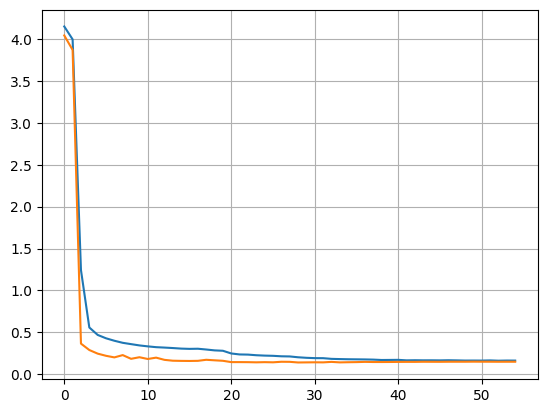

In [ ]:
for name 
plt.plot(lst_loss_train)
plt.plot(lst_loss_val)
plt.grid()
plt.show()

In [2]:
def ctc_decoder(logits, int_char_map, blank_label_idx):
    preds = []
    logits_cpu = logits.cpu()
    max_inds = torch.argmax(logits_cpu.detach(), dim=2).t().numpy()

    for ind in max_inds:
        merged_inds = []
        prev_idx = None
        for idx in ind:
            if idx != blank_label_idx and idx != prev_idx:
                merged_inds.append(idx)
            prev_idx = idx
        text = "".join([int_char_map.get(i, '') for i in merged_inds])
        preds.append(text)

    return preds

model_tload = [
    MorseNet(num_classes=num_classes),
    MorseNet2(num_classes=num_classes)
]

loaded_models = []
for _model in model_tload:
    loaded_model = _model.load_state_dict(torch.load(f'{_model.name()}.pth'))
    loaded_models.append(_model)
# model_load = MorseNet(num_classes=num_classes)
# model_load.load_state_dict(torch.load('MorseNet_0.89.pth'))
# model_load.eval()

with torch.no_grad():
    train_mess = []
    train_predicts = []

    for loader in train_dl:
        one_loader_out = []
        seq, test_target, _, mess = loader
        train_mess.extend(mess)

        for _model in loaded_models:
            _model.eval()
            logits = _model(seq)
            if isinstance(one_loader_out, list):
                one_loader_out = logits
            else:
                one_loader_out + logits
                
        mean_by_outs = one_loader_out / 2

        predicted_values = ctc_decoder(mean_by_outs, int_to_char, BLANK_IDX)
        train_predicts.extend(predicted_values)

    val_mess = []
    val_predicts = []

    for loader in val_dl :
        one_loader_out = []
        seq, test_target, _, mess = loader
        val_mess.extend(mess)

        for _model in loaded_models:
            _model.eval()
            logits = _model(seq)
            if isinstance(one_loader_out, list):
                one_loader_out = logits
            else:
                one_loader_out + logits

        mean_by_outs = one_loader_out / 2

        predicted_values = ctc_decoder(mean_by_outs, int_to_char, BLANK_IDX)
        val_predicts.extend(predicted_values)

import Levenshtein

mean_acc_test = np.mean([Levenshtein.ratio(test_pred, train_mess[ind]) for ind, test_pred in enumerate(train_predicts)])
mean_acc_val = np.mean([Levenshtein.ratio(val_pred, val_mess[ind]) for ind, val_pred in enumerate(val_predicts)])


print(f"Mean accurasu by The Levenshtein in train is : {mean_acc_test}")
print(f"Mean accurasu by The Levenshtein in validate is : {mean_acc_val}")

test_ds = MosreDataset(df=sample_data,
                        data_patch=DATASET_PATCH,
                        char_to_int=char_to_int,
                        train=False,
                        transforms=valid_audio_transforms)

test_dl = torch.utils.data.DataLoader(test_ds, batch_size=20, shuffle=False, collate_fn=my_collate)

with torch.no_grad():
    test_predicts = []
    for loader in test_dl:
        one_loader_out = []
        seq = loader

        for _model in loaded_models:
            _model.eval()
            logits = _model(seq)
            if isinstance(one_loader_out, list):
                one_loader_out = logits
            else:
                one_loader_out + logits

        mean_by_outs = one_loader_out / 2

        predicted_values = ctc_decoder(mean_by_outs, int_to_char, BLANK_IDX)
        test_predicts.extend(predicted_values)

sample_data.message = test_predicts
sample_data.to_csv('sample_submission.csv', index=False)


CNN размерность выхода: torch.Size([1, 32, 16, 89])
CNN число фичей: 512
Проекция из 512 в 512
CNN размерность выхода: torch.Size([1, 32, 32, 89])
CNN число фичей: 1024
Mean accurasu by The Levenshtein in train is : 0.9538611159239184
Mean accurasu by The Levenshtein in validate is : 0.9686582025302473


# Сбор sample_submission

In [ ]:
def ctc_decoder(logits, int_char_map, blank_label_idx):
    preds = []
    logits_cpu = logits.cpu()
    max_inds = torch.argmax(logits_cpu.detach(), dim=2).t().numpy()

    for ind in max_inds:
        merged_inds = []
        prev_idx = None
        for idx in ind:
            if idx != blank_label_idx and idx != prev_idx:
                merged_inds.append(idx)
            prev_idx = idx
        text = "".join([int_char_map.get(i, '') for i in merged_inds])
        preds.append(text)

    return preds

model_tload = [
    MorseNet(num_classes=num_classes),
    MorseNet2(num_classes=num_classes)
]

loaded_models = []
for _model in model_tload:
    loaded_model = _model.load_state_dict(torch.load(f'{_model.name()}.pth'))
    loaded_models.append(_model)


test_ds = MosreDataset(df=sample_data,
                        data_patch=DATASET_PATCH,
                        char_to_int=char_to_int,
                        train=False,
                        transforms=valid_audio_transforms)


test_dl = torch.utils.data.DataLoader(test_ds, batch_size=20, shuffle=False, collate_fn=my_collate)

with torch.no_grad():
    test_predicts = []
    for loader in test_dl:
        one_loader_out = []
        seq, test_target, _, mess = loader
        val_mess.extend(mess)

        for _model in loaded_models:
            _model.eval()
            logits = _model(seq)
            if isinstance(one_loader_out, list):
                one_loader_out = logits
            else:
                one_loader_out + logits

        mean_by_outs = one_loader_out / 2

        predicted_values = ctc_decoder(mean_by_outs, int_to_char, BLANK_IDX)
        test_predicts.extend(predicted_values)

sample_data.message = test_predicts
sample_data.to_csv('sample_submission.csv', index=False)

CNN размерность выхода: torch.Size([1, 32, 16, 89])
CNN число фичей: 512
Проекция из 512 в 512


# тест отдельной третей

In [4]:
def ctc_decoder(logits, int_char_map, blank_label_idx):
    preds = []
    logits_cpu = logits.cpu()
    max_inds = torch.argmax(logits_cpu.detach(), dim=2).t().numpy()

    for ind in max_inds:
        merged_inds = []
        prev_idx = None
        for idx in ind:
            if idx != blank_label_idx and idx != prev_idx:
                merged_inds.append(idx)
            prev_idx = idx
        text = "".join([int_char_map.get(i, '') for i in merged_inds])
        preds.append(text)

    return preds

model_load = MorseNet3(num_classes=num_classes)
model_load.load_state_dict(torch.load('MorseNet3.pth'))
model_load.eval()

test_ds = MosreDataset(df=sample_data,
                        data_patch=DATASET_PATCH,
                        char_to_int=char_to_int,
                        train=False,
                        transforms=valid_audio_transforms)

test_dl = torch.utils.data.DataLoader(test_ds, batch_size=20, shuffle=False, collate_fn=my_collate)
model_load.eval()

with torch.no_grad():
    test_predicts = []
    for loader in test_dl:
        seq = loader
        logits = model_load(seq)
        predicted_values = ctc_decoder(logits, int_to_char, BLANK_IDX)
        test_predicts.extend(predicted_values)

sample_data.message = test_predicts
sample_data.to_csv('sample_submission.csv', index=False)